## Import Libraries
The code used to implement the PID controller is taken from here: https://github.com/wfleshman/PID_Control.

In [1]:
import math
import random
import time
import pandas as pd

from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter 

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
use_cuda

False

## Plot Functions

In [2]:
plt.rcParams.update({'font.size': 18})
def plot_rewards(rewards):
    plt.plot(range(len(rewards)), rewards)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards")
    plt.show()
    plt.close()

def plot_smoothed(rewards, a):
    rewards_ema = pd.DataFrame(rewards).ewm(alpha = a).mean()
    plt.rcParams['figure.figsize'] = [10, 7]
    plt.plot(rewards_ema)
    plt.xlabel("Episodes")
    plt.ylabel("Rewards (EMA)")
    plt.show()
    plt.close()


## Save gifs of agent

In [3]:
def save_frames_as_gif(frames, path='./Visualizations/LunarLander/gifs/PID/', filename='pendulum_gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='pillow', fps= 120)

## PID Update

In [4]:
class Data():
    """tracks elements of the state"""
    def __init__(self):
        self.states = []
    
    def add(self,state):
        self.states.append(state)
        
    def graph(self, title):
        states = np.array(self.states).reshape(len(self.states),-1)
        plt.plot(states[:,0],label='x')
        plt.plot(states[:,1],label='y')
        plt.plot(states[:,2],label='vx')
        plt.plot(states[:,3],label='vy')
        plt.plot(states[:,4],label='theta')
        plt.plot(states[:,5],label='vtheta')
        plt.legend()
        plt.grid()
        plt.ylim(-1.1,1.1)
        plt.title(title)
        plt.ylabel('Value')
        plt.xlabel('Steps')
        fig = plt.gcf()
        fig.set_size_inches(16, 16)
        # plt.savefig(filename)
        plt.show()

def pid(state, params):
    """ calculates settings based on pid control """
    # PID parameters
    kp_alt = params[0]  # proportional altitude
    kd_alt = params[1]  # derivative altitude
    kp_ang = params[2]  # proportional angle
    kd_ang = params[3]  # derivative angle
    
    # Calculate setpoints (target values)
    # state vector = [x, y, x linear velocity, y linear velocity, angle, angular velocity, 2 landing booleans]
    alt_tgt = np.abs(state[0])
    ang_tgt = (.25*np.pi)*(state[0]+state[2])

    # Calculate error values
    alt_error = (alt_tgt - state[1])
    ang_error = (ang_tgt - state[4])
    
    # Use PID to get adjustments
    alt_adj = kp_alt*alt_error + kd_alt*state[3]
    ang_adj = kp_ang*ang_error + kd_ang*state[5]
        
    # Gym wants them as np array (-1,1)
    a = np.array([alt_adj, ang_adj])
    a = np.clip(a, -1, +1)
    
    # If the legs are on the ground we made it, kill engines
    if(state[6] or state[7]):
        a[:] = 0   
    return a

def run(params, env, max_steps):
    """ runs an episode given pid parameters """
    data = Data() 
    done = False
    state = env.reset()
    data.add(state)
    total = 0
    for _ in range(max_steps):
        a = pid(state,params)
        state,reward,done,_ = env.step(a)
        total += reward
        data.add(state)
        if done:
            break
    return total, data

def optimize(params, current_score, env, step, max_steps, run_steps = 15):
    """ runs a step of randomized hill climbing """

    # add gaussian noise (less noise as n_steps increases)
    test_params = params + np.random.normal(0,20.0/step,size=params.shape)
    
    # test params over 5 trial avg
    scores = []
    for trial in range(run_steps):
        score, _ = run(test_params,env, max_steps)
        scores.append(score)
    avg = np.mean(scores)
    
    # update params if improved
    if avg > current_score:
        return test_params,avg
    else:
        return params,current_score

## Task 1 (training)

/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviou

Step: 0 Score: -300 Params: [0 0 0 0]
Step: 10 Score: -113.57612248853161 Params: [ 3.07789076 -1.17967944  0.66856971  1.30386308]
Step: 20 Score: 263.91169787621243 Params: [ 3.17590682 -4.49264639 -3.98038686  2.26000591]
Step: 30 Score: 274.9749775663876 Params: [ 4.19140527 -4.09985917 -3.9236188   1.87412595]
Step: 40 Score: 274.9749775663876 Params: [ 4.19140527 -4.09985917 -3.9236188   1.87412595]
Step: 50 Score: 274.9749775663876 Params: [ 4.19140527 -4.09985917 -3.9236188   1.87412595]
Step: 60 Score: 280.96016740487187 Params: [ 4.04939656 -4.25851435 -4.26187371  1.74051246]
Step: 70 Score: 282.59051696858694 Params: [ 4.36959017 -3.97385767 -4.66836762  1.73106698]
Step: 80 Score: 282.59051696858694 Params: [ 4.36959017 -3.97385767 -4.66836762  1.73106698]
Step: 90 Score: 282.59051696858694 Params: [ 4.36959017 -3.97385767 -4.66836762  1.73106698]
Step: 100 Score: 282.59051696858694 Params: [ 4.36959017 -3.97385767 -4.66836762  1.73106698]
Step: 110 Score: 283.063046401834

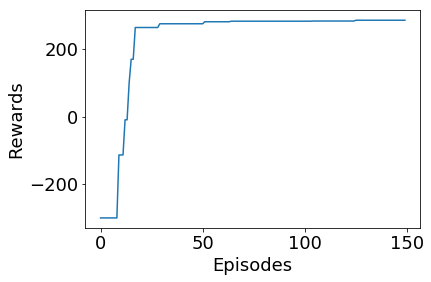

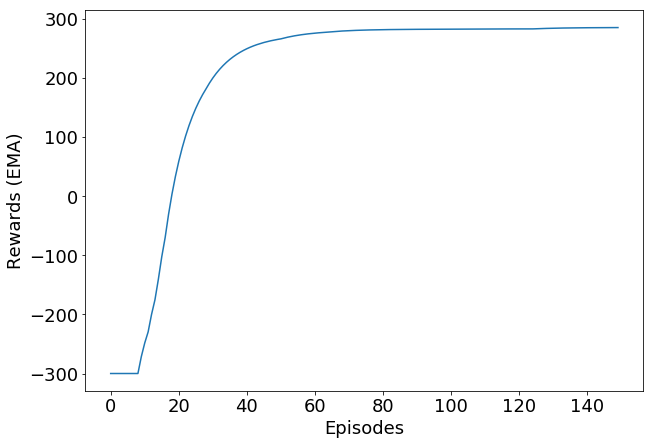

In [5]:
rewards_train = {}
rewards_test = {}
rewards_train['task1'] = []

num_eps = 150
np.random.seed(24)
random.seed(24)
max_steps = 600
batch_size  = 128

task1 = gym.make("LunarLander-v2", continuous = True)
task1.reset(seed = 24)

# Random Hill Climb over params
params = np.array([0,0,0,0])
score = -300 # bad starting score
for steps in range(num_eps):
    params,score = optimize(params,score,task1,steps+1, max_steps)
    rewards_train['task1'].append(score)
    if steps%10 == 0:
        print("Step:",steps,"Score:",score,"Params:",params)

print('Training Complete')
rewards_task11 = rewards_train['task1']
plot_rewards(rewards_task11)
plot_smoothed(rewards_task11, 0.1)

## Task 1 (test)

Task 1 Complete


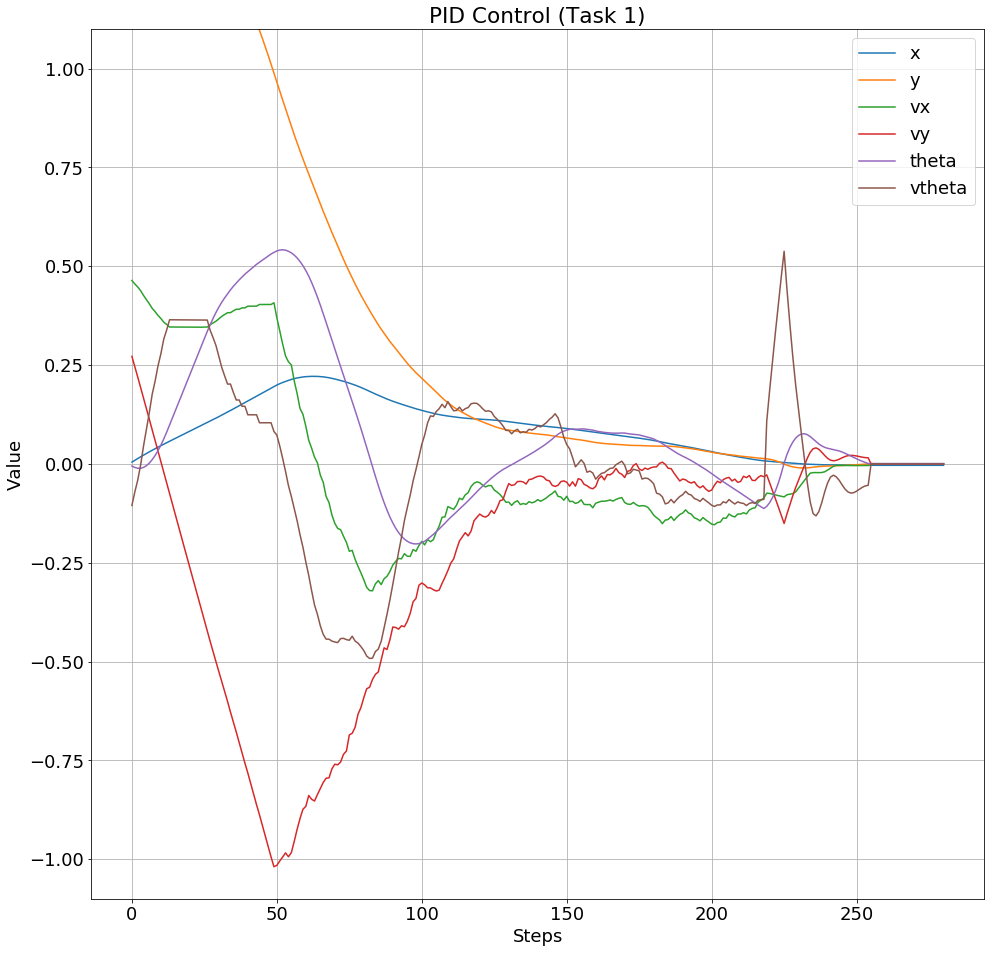

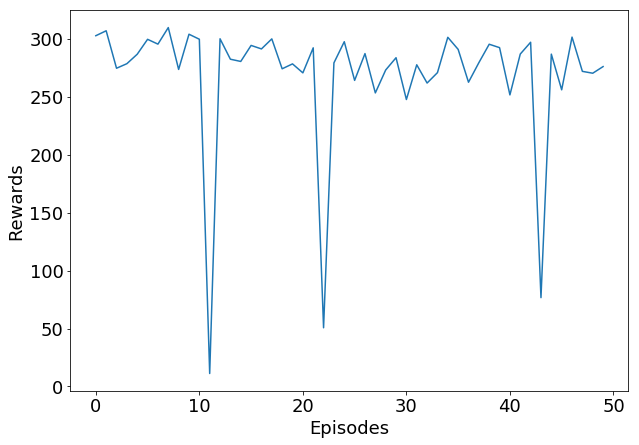

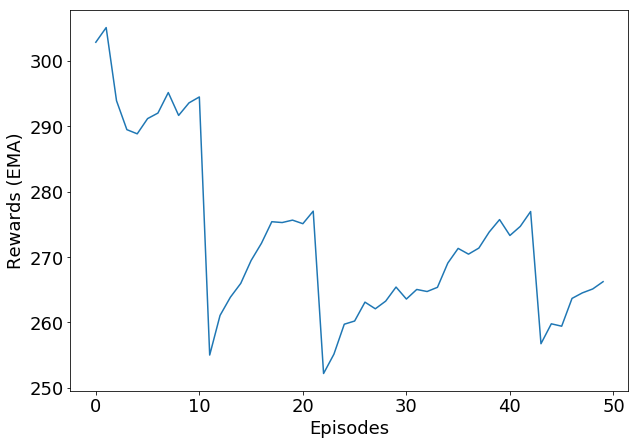

In [6]:
rewards_test['task1'] = []
test_eps = 50

# Get data for final run
for trial in range(test_eps):
    score, data = run(params, task1, max_steps)
    rewards_test['task1'].append(score)

print('Task 1 Complete')
data.graph("PID Control (Task 1)")
rewards_env = rewards_test['task1']
plot_rewards(rewards_env)
plot_smoothed(rewards_env, 0.1)

/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/core.py:52: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


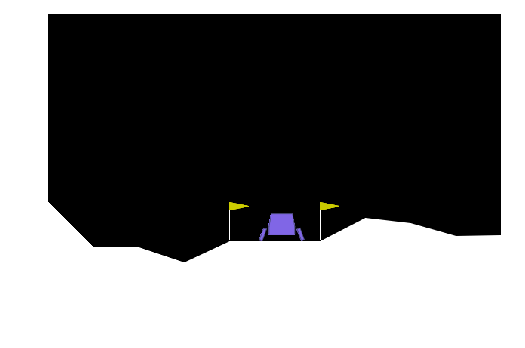

In [7]:
# Save video of env agent
def modified_run(params, env, max_steps, frames):
    """ runs an episode given pid parameters """
    done = False
    state = env.reset()
    for _ in range(max_steps):
        frames.append(env.render(mode="rgb_array"))
        a = pid(state,params)
        state,reward,done,_ = env.step(a)
        if done:
            break

frames = []
for i in range(2):
    state = task1.reset()
    modified_run(params, task1, max_steps, frames)
task1.close()
save_frames_as_gif(frames, filename='lunar_lander_task1_PID.gif')

## Task 2 (training)

/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviou

Step: 0 Score: -300 Params: [0 0 0 0]
Step: 10 Score: -199.34424688042782 Params: [ 3.07789076 -1.17967944  0.66856971  1.30386308]
Step: 20 Score: 99.52984298606353 Params: [ 2.39202998 -2.80097302 -2.38008382  2.00649832]
Step: 30 Score: 99.52984298606353 Params: [ 2.39202998 -2.80097302 -2.38008382  2.00649832]
Step: 40 Score: 99.52984298606353 Params: [ 2.39202998 -2.80097302 -2.38008382  2.00649832]
Step: 50 Score: 166.4168296566636 Params: [ 1.9362463  -2.28815078 -2.54974301  0.97181389]
Step: 60 Score: 166.4168296566636 Params: [ 1.9362463  -2.28815078 -2.54974301  0.97181389]
Step: 70 Score: 219.55647083016902 Params: [ 1.9830102  -2.3696581  -3.07027845  1.15482682]
Step: 80 Score: 219.55647083016902 Params: [ 1.9830102  -2.3696581  -3.07027845  1.15482682]
Step: 90 Score: 219.55647083016902 Params: [ 1.9830102  -2.3696581  -3.07027845  1.15482682]
Step: 100 Score: 219.55647083016902 Params: [ 1.9830102  -2.3696581  -3.07027845  1.15482682]
Step: 110 Score: 219.55647083016902

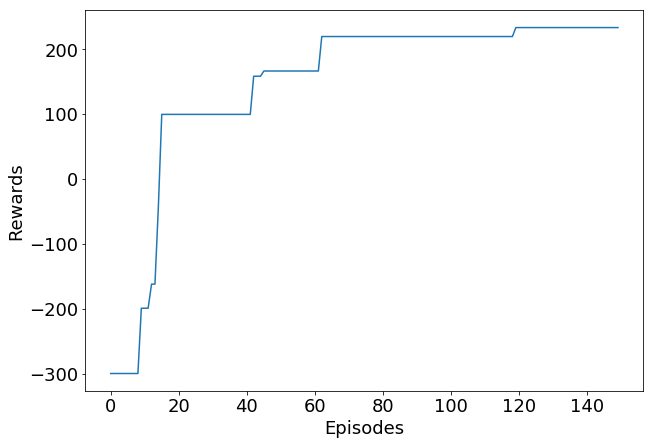

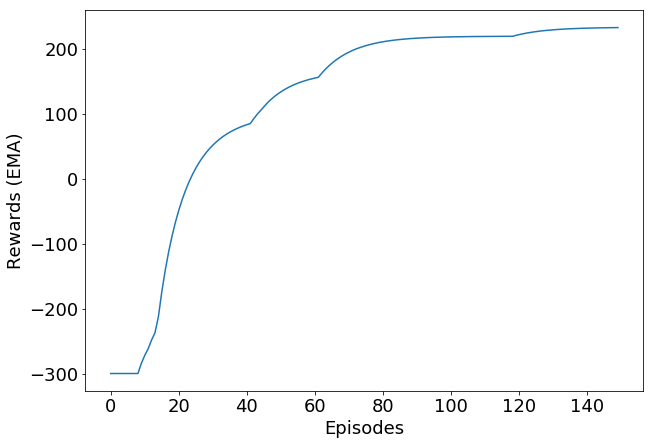

In [84]:
rewards_train['task2'] = []

num_eps = 150
np.random.seed(24)
random.seed(24)
max_steps = 600
batch_size  = 128

task2 = gym.make("LunarLander-v2", continuous = True, enable_wind = True, wind_power = 20)
task2.reset(seed = 24)

# Random Hill Climb over params
params = np.array([0,0,0,0])
score = -300 # bad starting score
for steps in range(num_eps):
    params,score = optimize(params,score,task2,steps+1, max_steps, 5)
    rewards_train['task2'].append(score)
    if steps%10 == 0:
        print("Step:",steps,"Score:",score,"Params:",params)

print('Training Complete')
rewards_task2 = rewards_train['task2']
plot_rewards(rewards_task2)
plot_smoothed(rewards_task2, 0.1)

## Task 2 (test)

Task 1 Complete


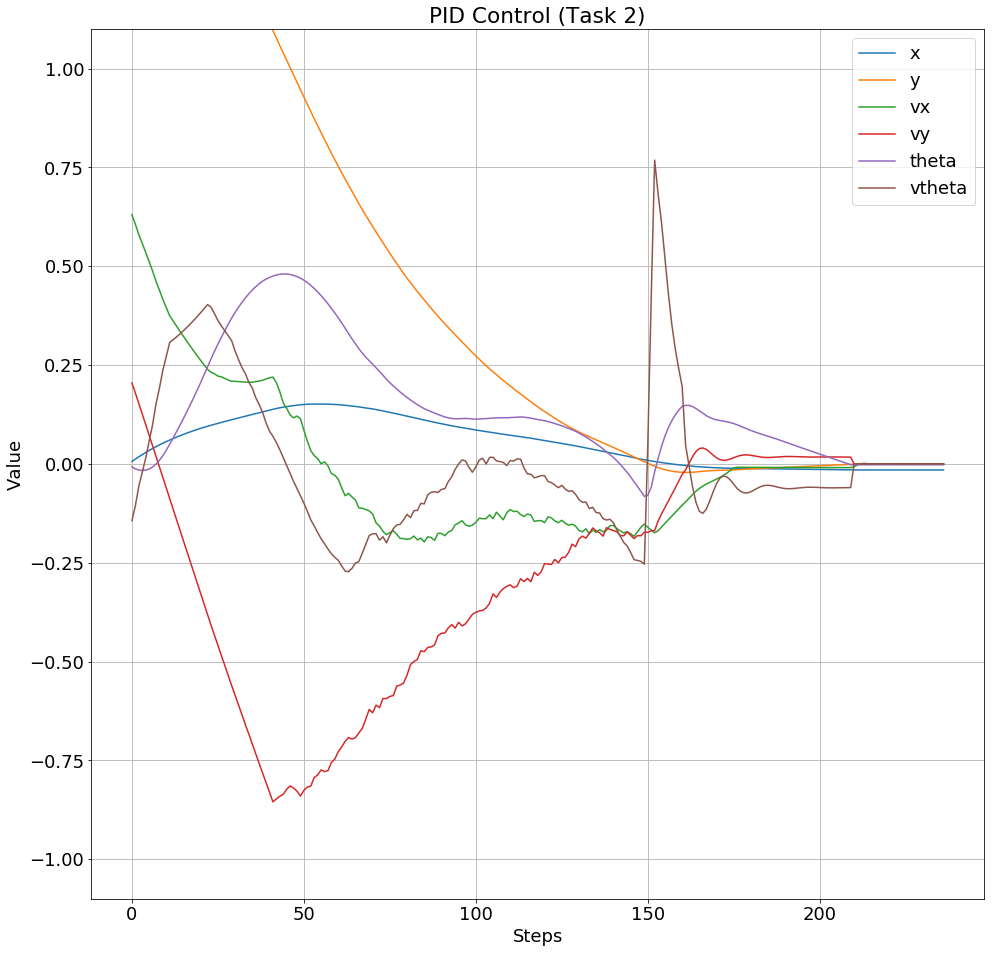

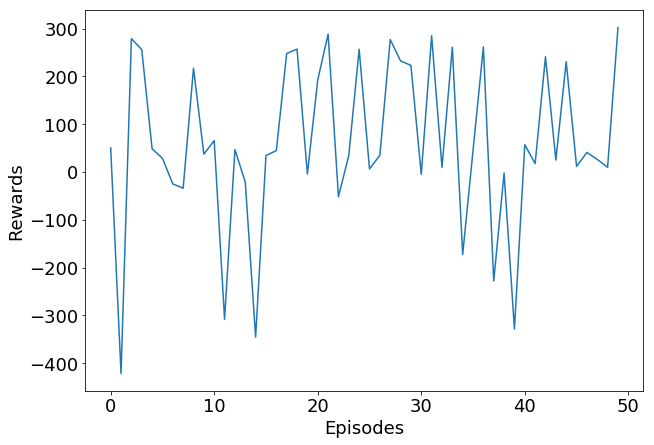

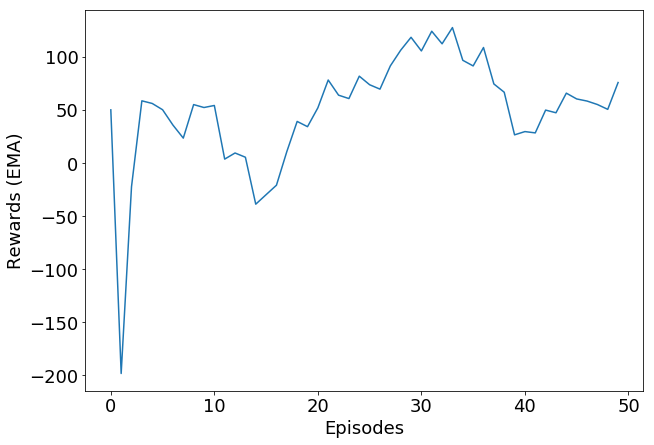

In [85]:
rewards_test['task2'] = []
test_eps = 50

# Get data for final run
for trial in range(test_eps):
    score, data = run(params, task2, max_steps)
    rewards_test['task2'].append(score)

print('Task 1 Complete')
data.graph("PID Control (Task 2)")
rewards_env = rewards_test['task2']
plot_rewards(rewards_env)
plot_smoothed(rewards_env, 0.1)

/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/core.py:52: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


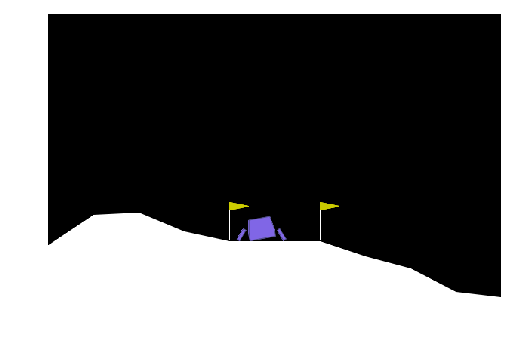

In [86]:
frames = []
for i in range(2):
    state = task2.reset()
    modified_run(params, task2, max_steps, frames)
task2.close()
save_frames_as_gif(frames, filename='lunar_lander_task2_PID.gif')

## Task 3 (training)

/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviou

Step: 0 Score: -300 Params: [0 0 0 0]
Step: 10 Score: -244.31829127732738 Params: [ 3.07789076 -1.17967944  0.66856971  1.30386308]
Step: 20 Score: 128.86039371307638 Params: [ 3.17590682 -4.49264639 -3.98038686  2.26000591]
Step: 30 Score: 221.20563615119286 Params: [ 4.9451459  -4.83853956 -3.49418012  1.00102735]
Step: 40 Score: 221.86846724500418 Params: [ 4.71251441 -3.60897015 -3.81922893  1.16634711]
Step: 50 Score: 257.5828050106315 Params: [ 5.11377473 -3.70805166 -4.57059306  1.21711295]
Step: 60 Score: 257.5828050106315 Params: [ 5.11377473 -3.70805166 -4.57059306  1.21711295]
Step: 70 Score: 259.1034166049815 Params: [ 5.8170461  -3.5831565  -4.18394383  1.16320403]
Step: 80 Score: 259.36719873156676 Params: [ 5.76190029 -3.32791528 -4.2002079   0.75262906]
Step: 90 Score: 266.12950006227607 Params: [ 5.53965294 -3.30697165 -4.54620398  1.00468252]
Step: 100 Score: 266.12950006227607 Params: [ 5.53965294 -3.30697165 -4.54620398  1.00468252]
Step: 110 Score: 266.129500062276

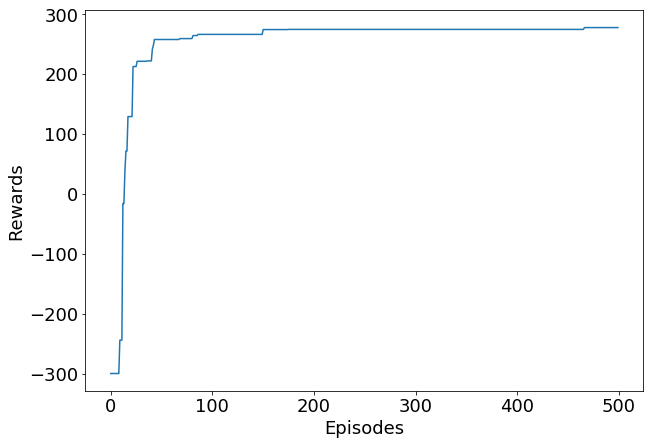

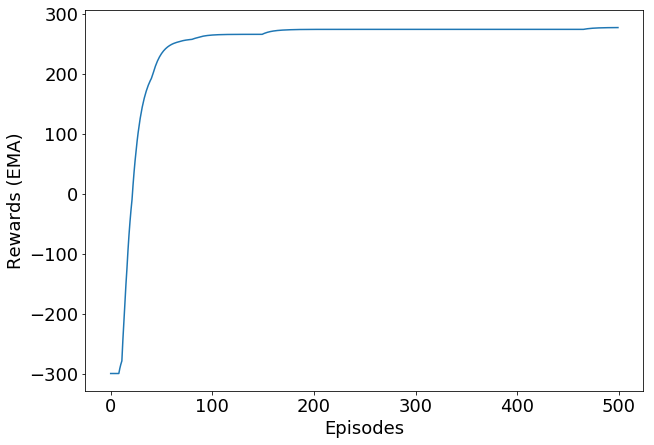

In [11]:
rewards_train['task3'] = []

num_eps = 500
np.random.seed(24)
random.seed(24)
max_steps = 600
batch_size  = 128

task3 = gym.make("LunarLander-v2", continuous = True, gravity = -7)
task3.reset(seed = 24)

# Random Hill Climb over params
params = np.array([0,0,0,0])
score = -300 # bad starting score
for steps in range(num_eps):
    params,score = optimize(params,score,task3,steps+1, max_steps, 30)
    rewards_train['task3'].append(score)
    if steps%10 == 0:
        print("Step:",steps,"Score:",score,"Params:",params)

print('Training Complete')
rewards_task3 = rewards_train['task3']
plot_rewards(rewards_task3)
plot_smoothed(rewards_task3, 0.1)

## Task 3 (test)

Task 1 Complete


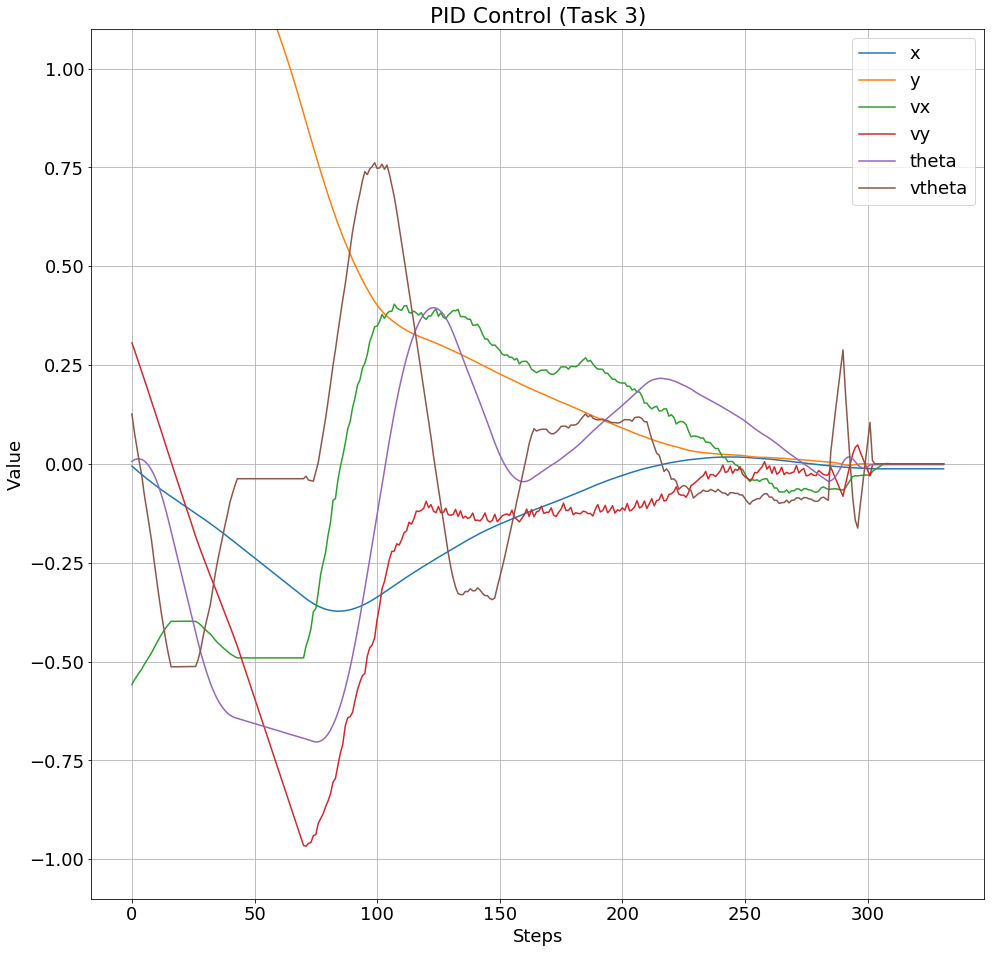

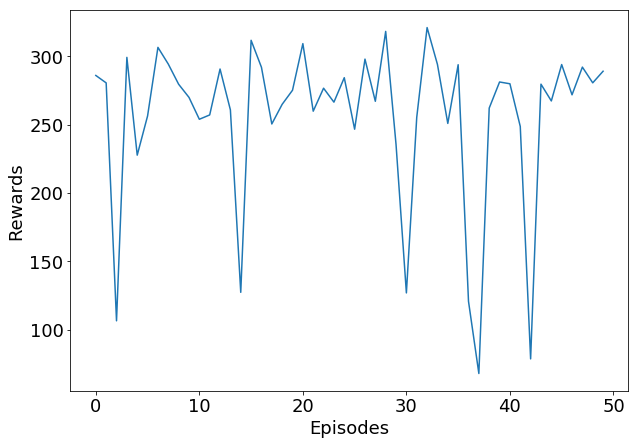

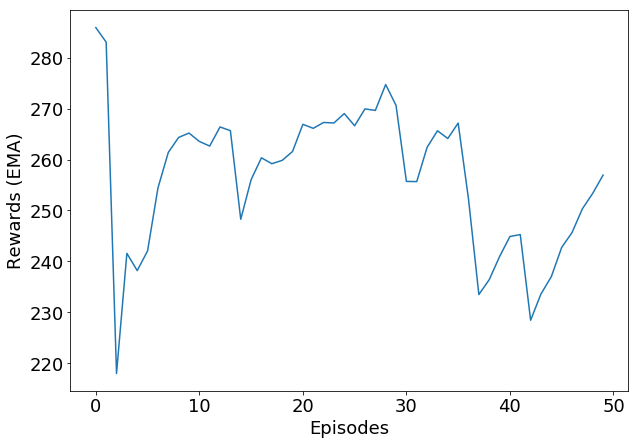

In [12]:
rewards_test['task3'] = []
test_eps = 50

# Get data for final run
for trial in range(test_eps):
    score, data = run(params, task3, max_steps)
    rewards_test['task3'].append(score)

print('Task 1 Complete')
data.graph("PID Control (Task 3)")
rewards_env = rewards_test['task3']
plot_rewards(rewards_env)
plot_smoothed(rewards_env, 0.1)

/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/core.py:52: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


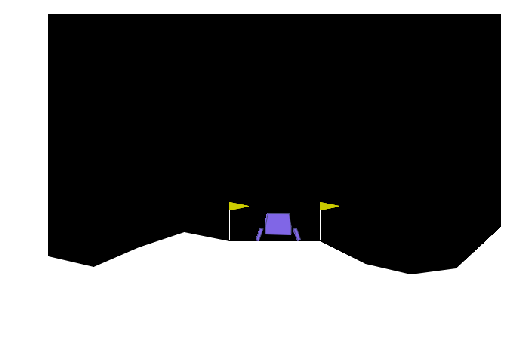

In [13]:
frames = []
for i in range(2):
    state = task3.reset()
    modified_run(params, task3, max_steps, frames)
task3.close()
save_frames_as_gif(frames, filename='lunar_lander_task3_PID.gif')

## Task 4 (training)

/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviou

Step: 0 Score: -300 Params: [0 0 0 0]
Step: 10 Score: -300 Params: [0 0 0 0]
Step: 20 Score: 10.46159725121348 Params: [ 1.71283337 -4.00207883 -3.56939253  1.61670836]
Step: 30 Score: 15.090020050690136 Params: [ 2.72833182 -3.60929162 -3.51262446  1.2308284 ]
Step: 40 Score: 71.30282015327091 Params: [ 2.61875184 -1.79562034 -4.47380044  1.90454416]
Step: 50 Score: 90.60672594763017 Params: [ 2.21617798 -1.60902137 -4.53445106  1.3505237 ]
Step: 60 Score: 91.09199843827075 Params: [ 2.03831631 -1.53396174 -5.03850049  1.09947298]
Step: 70 Score: 91.09199843827075 Params: [ 2.03831631 -1.53396174 -5.03850049  1.09947298]
Step: 80 Score: 96.77028356664437 Params: [ 2.23909249 -1.50114333 -5.38066764  1.51944815]
Step: 90 Score: 100.34265093543989 Params: [ 2.16256328 -1.65465215 -5.28474846  1.89338337]
Step: 100 Score: 100.34265093543989 Params: [ 2.16256328 -1.65465215 -5.28474846  1.89338337]
Step: 110 Score: 100.34265093543989 Params: [ 2.16256328 -1.65465215 -5.28474846  1.8933833

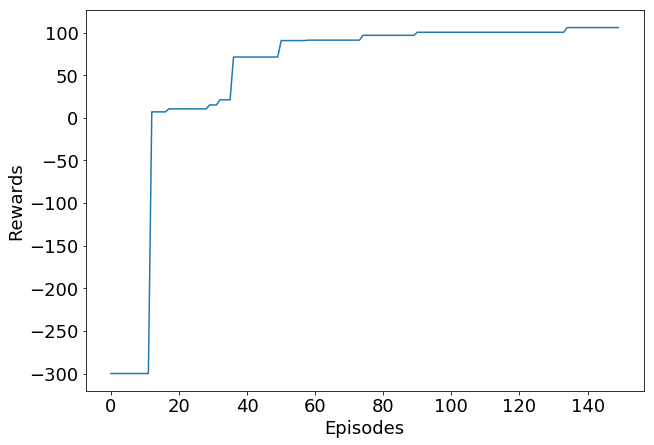

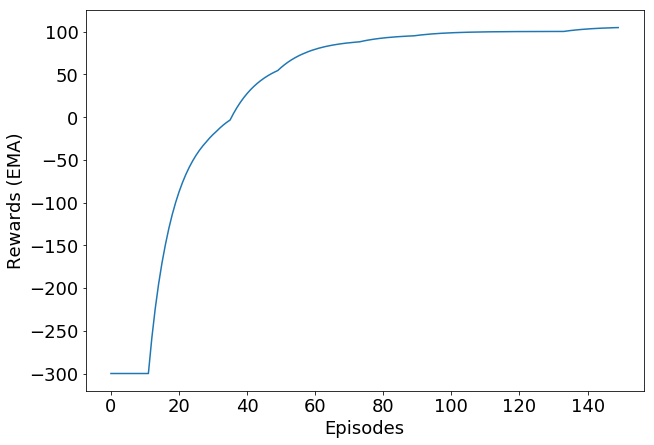

In [50]:
rewards_train['task4'] = []

num_eps = 150
np.random.seed(24)
random.seed(24)
max_steps = 600
batch_size  = 128

task4 = gym.make("LunarLander-v2", continuous = True, gravity = -7, enable_wind = True, wind_power = 20)
task4.reset(seed = 24)

# Random Hill Climb over params
params = np.array([0,0,0,0])
score = -300 # bad starting score
for steps in range(num_eps):
    params,score = optimize(params,score,task4,steps+1, max_steps, 60)
    rewards_train['task4'].append(score)
    if steps%10 == 0:
        print("Step:",steps,"Score:",score,"Params:",params)

print('Training Complete')
rewards_task4 = rewards_train['task4']
plot_rewards(rewards_task4)
plot_smoothed(rewards_task4, 0.1)

## Task 4 (test)

Task 1 Complete


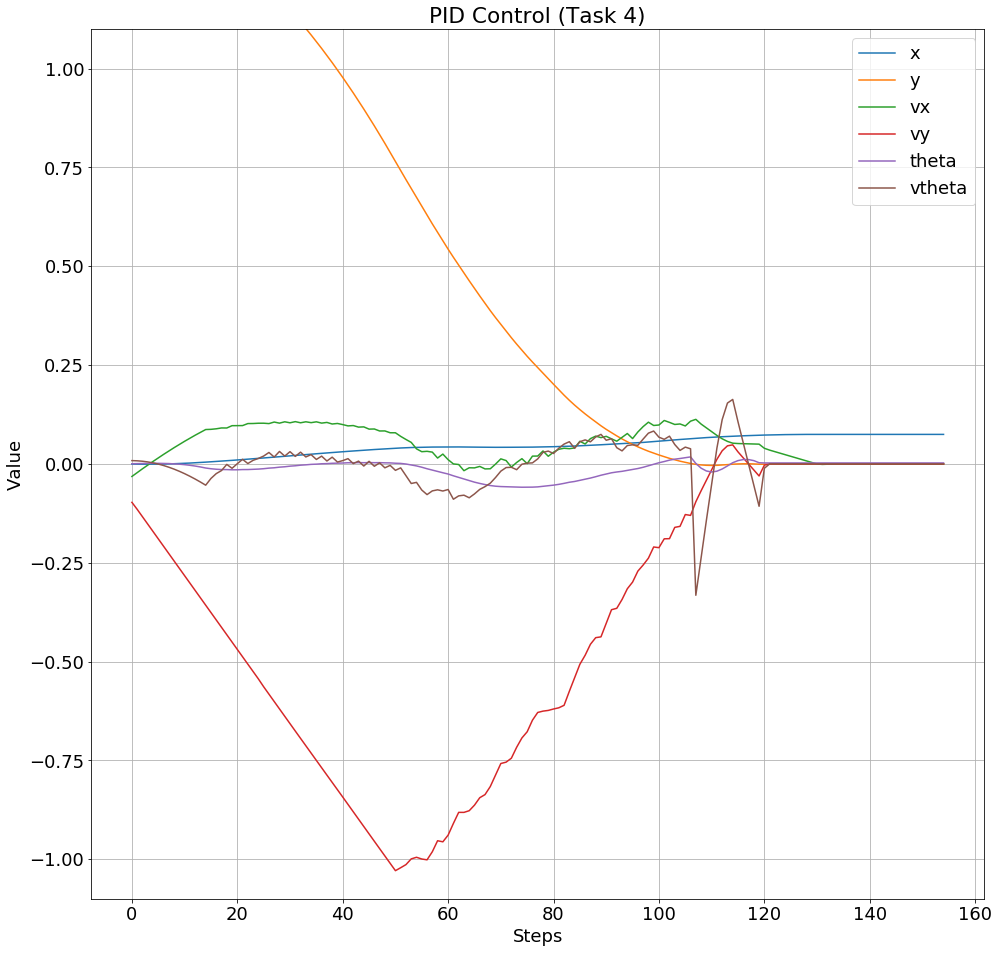

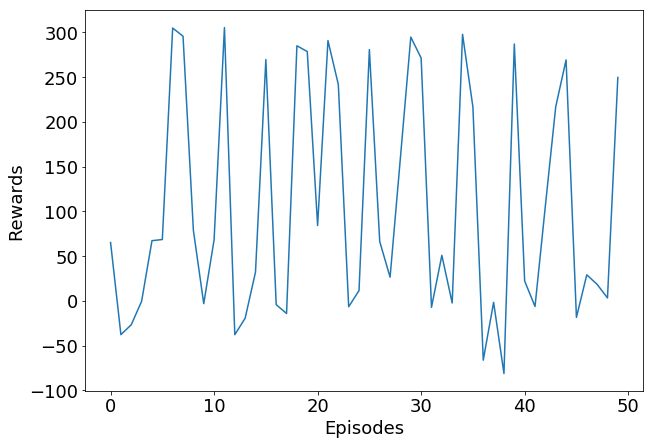

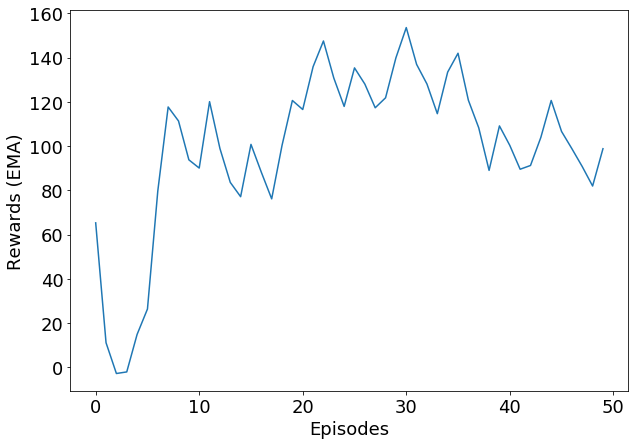

In [51]:
rewards_test['task4'] = []
test_eps = 50

# Get data for final run
for trial in range(test_eps):
    score, data = run(params, task4, max_steps)
    rewards_test['task4'].append(score)

print('Task 1 Complete')
data.graph("PID Control (Task 4)")
rewards_env = rewards_test['task4']
plot_rewards(rewards_env)
plot_smoothed(rewards_env, 0.1)

/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/core.py:52: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


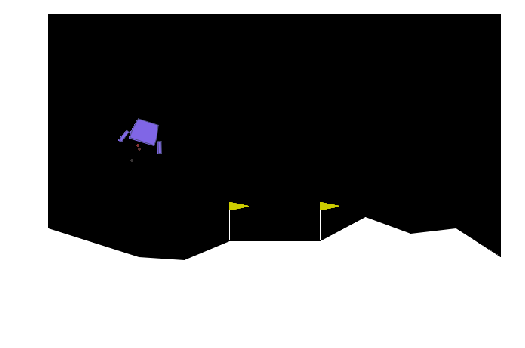

In [52]:
frames = []
for i in range(2):
    state = task4.reset()
    modified_run(params, task4, max_steps, frames)
task4.close()
save_frames_as_gif(frames, filename='lunar_lander_task4_PID.gif')

## Task 5 (training)

Step: 0 Score: -300 Params: [0 0 0 0]
Step: 10 Score: -300 Params: [0 0 0 0]
Step: 20 Score: 125.1551551266804 Params: [ 1.60524719 -3.63339366 -3.90510425  0.73078588]
Step: 30 Score: 155.36618197316844 Params: [ 2.67924745 -4.1176174  -2.31123    -0.00731224]
Step: 40 Score: 155.36618197316844 Params: [ 2.67924745 -4.1176174  -2.31123    -0.00731224]
Step: 50 Score: 219.3580523432931 Params: [ 4.15648663 -2.16017887 -2.32332477  0.29406107]
Step: 60 Score: 237.64942705561705 Params: [ 4.34686306 -1.84576451 -2.89344284  0.05730121]
Step: 70 Score: 245.7917005889192 Params: [ 4.39362696 -1.92727183 -3.41397828  0.24031414]
Step: 80 Score: 245.7917005889192 Params: [ 4.39362696 -1.92727183 -3.41397828  0.24031414]
Step: 90 Score: 245.7917005889192 Params: [ 4.39362696 -1.92727183 -3.41397828  0.24031414]
Step: 100 Score: 257.15364176964056 Params: [ 4.59956451 -2.1766418  -3.45587105  0.43942026]
Step: 110 Score: 257.15364176964056 Params: [ 4.59956451 -2.1766418  -3.45587105  0.439420

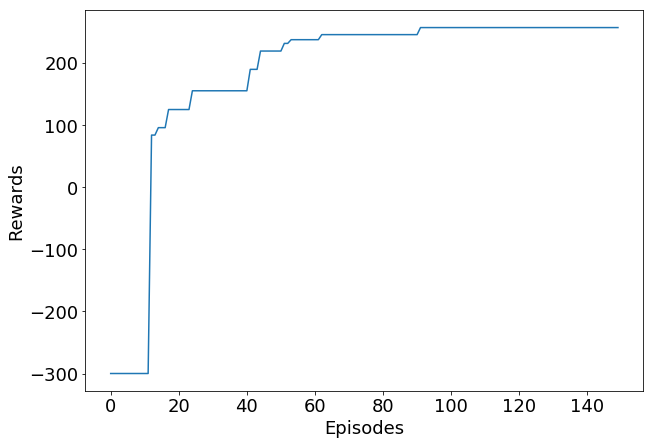

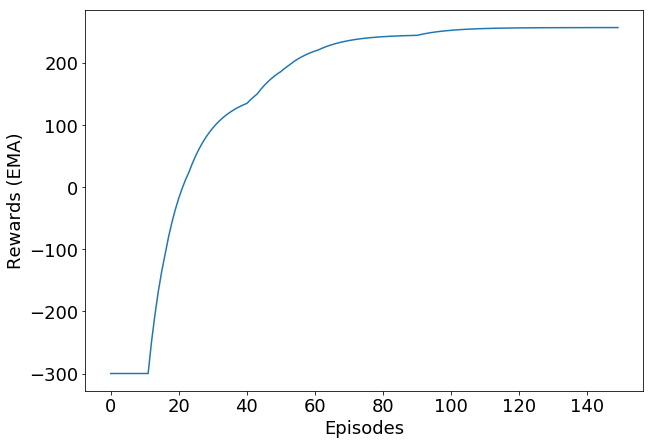

In [33]:
rewards_train['task5'] = []

num_eps = 150
np.random.seed(24)
random.seed(24)
max_steps = 600
batch_size  = 128

task5 = gym.make("LunarLander-v2", continuous = True, gravity = -5)
task5.reset(seed = 24)

# Random Hill Climb over params
params = np.array([0,0,0,0])
score = -300 # bad starting score
for steps in range(num_eps):
    params,score = optimize(params,score,task5,steps+1, max_steps, 30)
    rewards_train['task5'].append(score)
    if steps%10 == 0:
        print("Step:",steps,"Score:",score,"Params:",params)

print('Training Complete')
rewards_task5 = rewards_train['task5']
plot_rewards(rewards_task5)
plot_smoothed(rewards_task5, 0.1)

## Task 5 (test)

Task 1 Complete


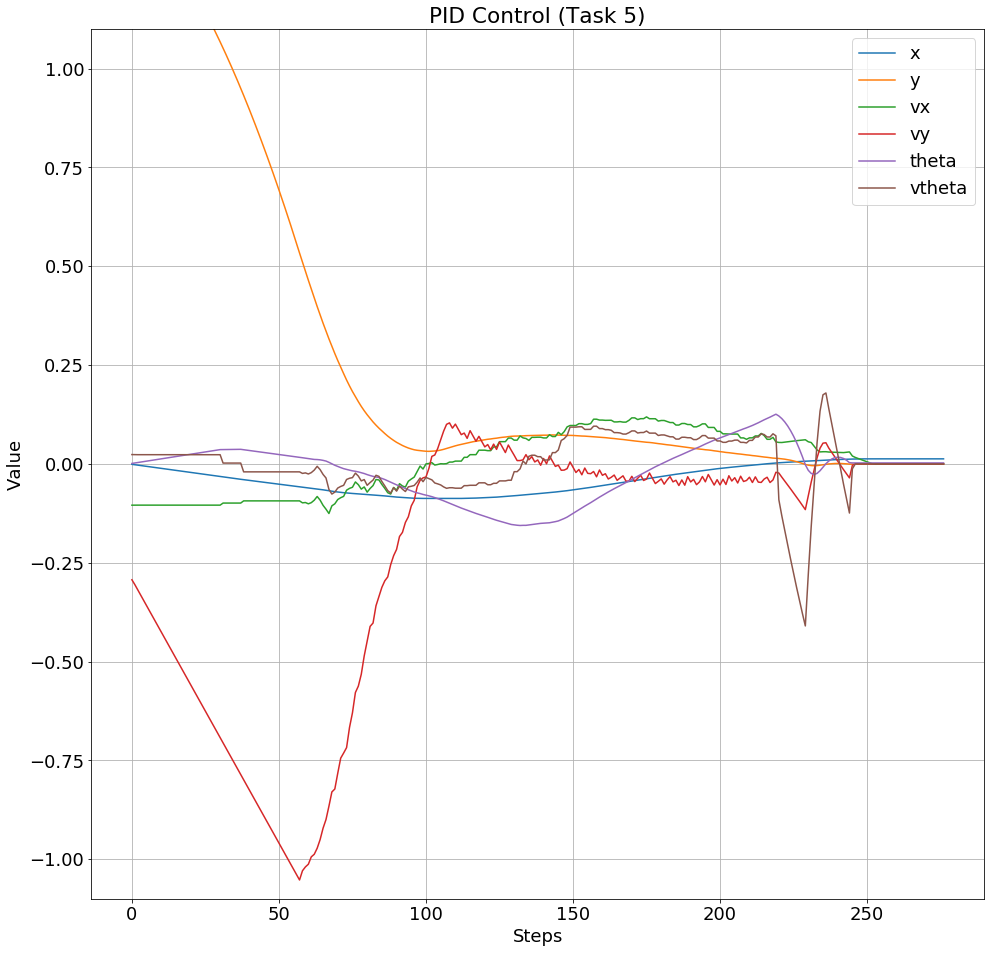

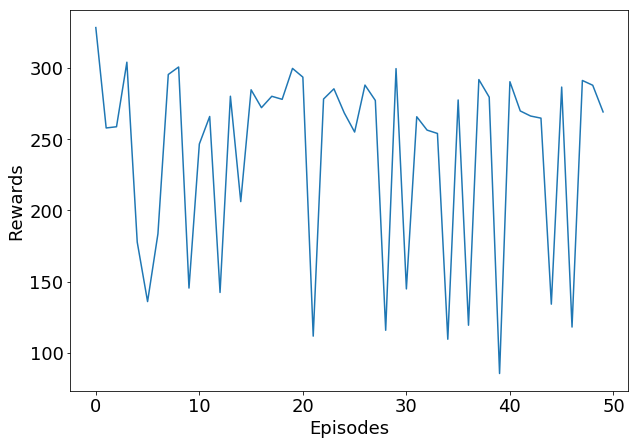

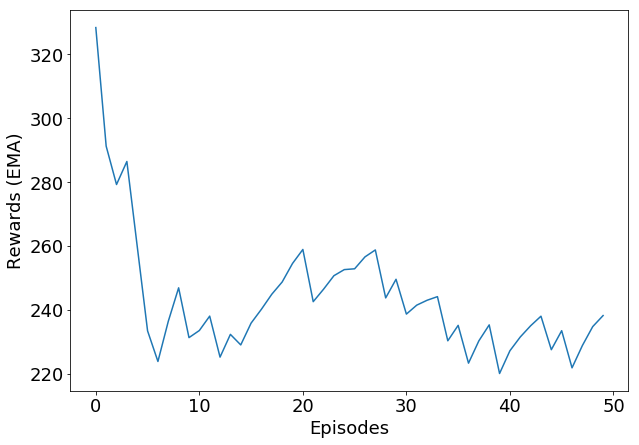

In [34]:
rewards_test['task5'] = []
test_eps = 50

# Get data for final run
for trial in range(test_eps):
    score, data = run(params, task5, max_steps)
    rewards_test['task5'].append(score)

print('Task 1 Complete')
data.graph("PID Control (Task 5)")
rewards_env = rewards_test['task5']
plot_rewards(rewards_env)
plot_smoothed(rewards_env, 0.1)

/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/core.py:52: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


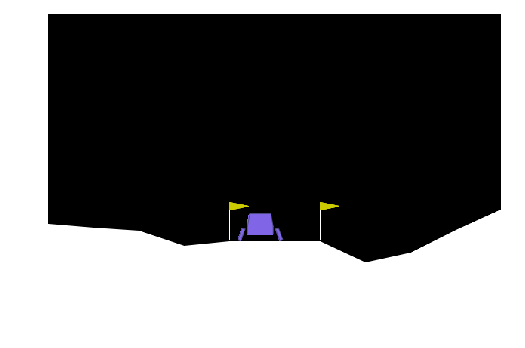

In [35]:
frames = []
for i in range(2):
    state = task5.reset()
    modified_run(params, task5, max_steps, frames)
task5.close()
save_frames_as_gif(frames, filename='lunar_lander_task5_PID.gif')

## Task 6 (training)

/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviou

Step: 0 Score: -300 Params: [0 0 0 0]
Step: 10 Score: -300 Params: [0 0 0 0]
Step: 20 Score: 24.996638261353684 Params: [ 0.82137034 -1.94172029 -2.30480121  0.47727829]
Step: 30 Score: 24.996638261353684 Params: [ 0.82137034 -1.94172029 -2.30480121  0.47727829]
Step: 40 Score: 70.69907626853438 Params: [ 1.20002794 -0.7885213  -2.69782801  0.62434014]
Step: 50 Score: 70.69907626853438 Params: [ 1.20002794 -0.7885213  -2.69782801  0.62434014]
Step: 60 Score: 89.82018825658523 Params: [ 1.23110836 -0.94747763 -2.86399949  0.36882733]
Step: 70 Score: 89.82018825658523 Params: [ 1.23110836 -0.94747763 -2.86399949  0.36882733]
Step: 80 Score: 89.82018825658523 Params: [ 1.23110836 -0.94747763 -2.86399949  0.36882733]
Step: 90 Score: 89.82018825658523 Params: [ 1.23110836 -0.94747763 -2.86399949  0.36882733]
Step: 100 Score: 89.82018825658523 Params: [ 1.23110836 -0.94747763 -2.86399949  0.36882733]
Step: 110 Score: 89.82018825658523 Params: [ 1.23110836 -0.94747763 -2.86399949  0.36882733]

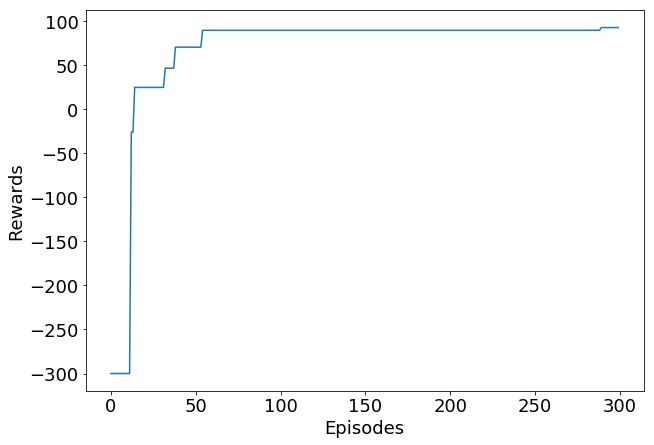

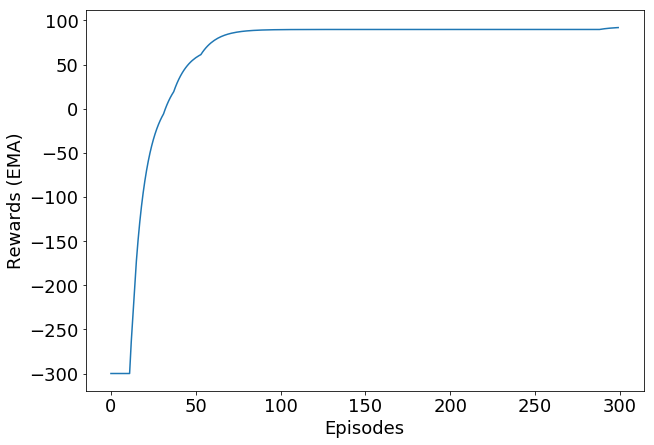

In [79]:
rewards_train['task6'] = []

num_eps = 300
np.random.seed(24)
random.seed(24)
max_steps = 600
batch_size  = 128

task6 = gym.make("LunarLander-v2", continuous = True, gravity = -5, enable_wind = True, wind_power = 20)
task6.reset(seed = 24)

# Random Hill Climb over params
params = np.array([0,0,0,0])
score = -300 # bad starting score
for steps in range(num_eps):
    params,score = optimize(params,score,task6,steps+1, max_steps)
    rewards_train['task6'].append(score)
    if steps%10 == 0:
        print("Step:",steps,"Score:",score,"Params:",params)

print('Training Complete')
rewards_task6 = rewards_train['task6']
plot_rewards(rewards_task6)
plot_smoothed(rewards_task6, 0.1)

## Task 6 (test)

Task 1 Complete


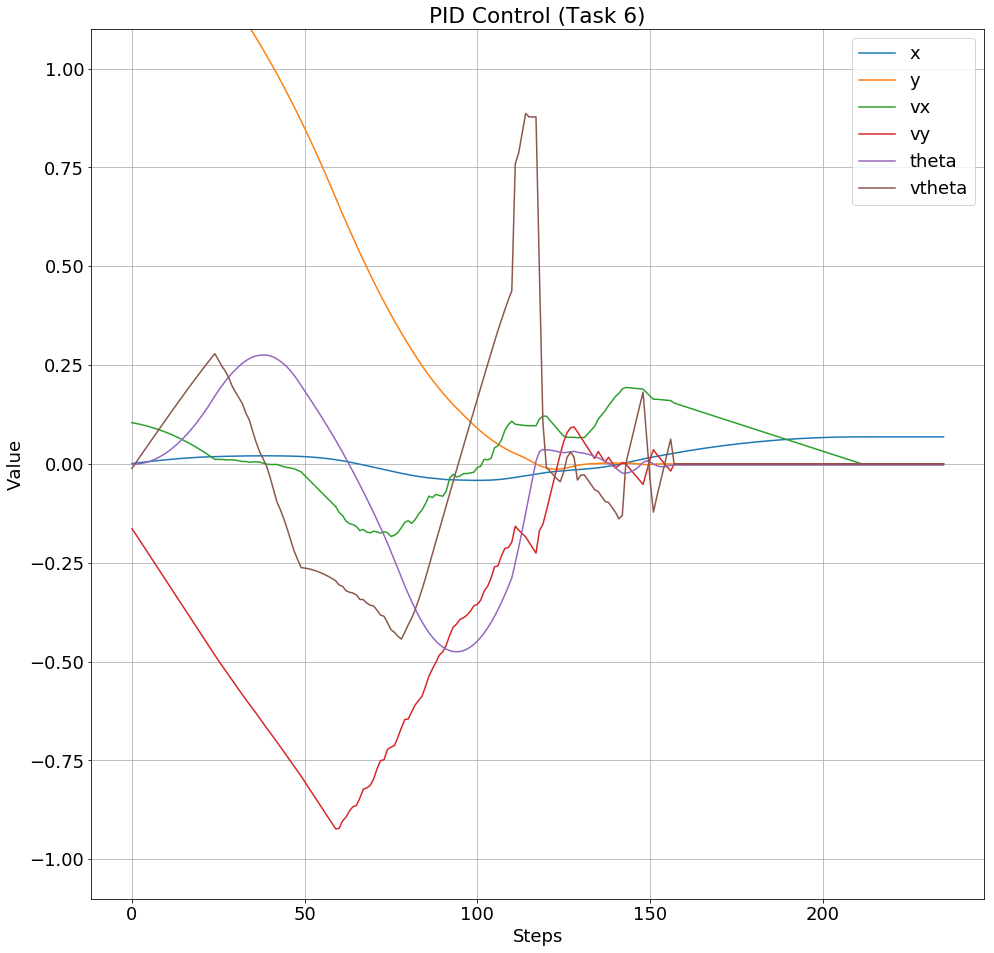

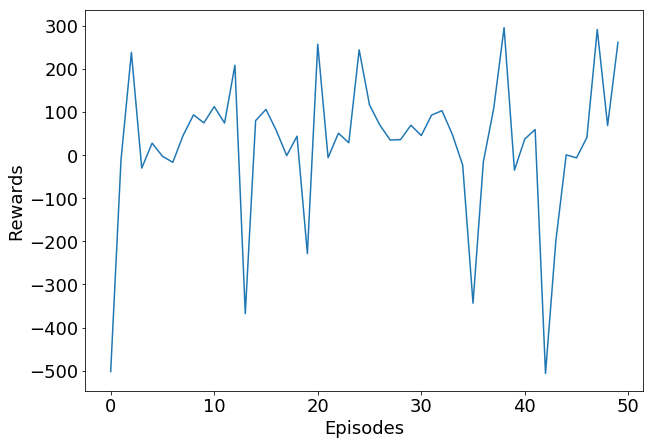

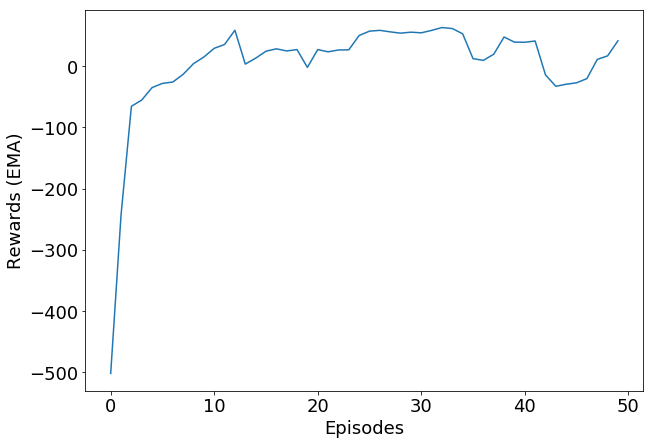

In [80]:
rewards_test['task6'] = []
test_eps = 50

# Get data for final run
for trial in range(test_eps):
    score, data = run(params, task6, max_steps)
    rewards_test['task6'].append(score)

print('Task 1 Complete')
data.graph("PID Control (Task 6)")
rewards_env = rewards_test['task6']
plot_rewards(rewards_env)
plot_smoothed(rewards_env, 0.1)

/Users/kenneth01px2018/DSC20/anaconda3/lib/python3.7/site-packages/gym/core.py:52: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


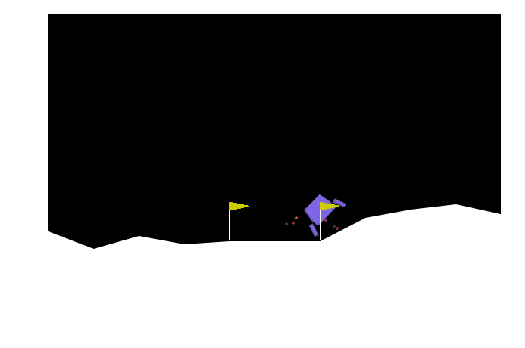

In [81]:
frames = []
for i in range(2):
    state = task6.reset()
    modified_run(params, task6, max_steps, frames)
task6.close()
save_frames_as_gif(frames, filename='lunar_lander_task6_PID.gif')

### Test Results

In [87]:
test_df = pd.DataFrame(rewards_test)
# train_df = pd.DataFrame(rewards_train)
test_df.to_csv('./Data/test_rewards_lunar_lander_PID.csv')

In [89]:
# print("****TRAINING RESULTS****")
# print(train_df.tail(50).mean())
print("****TEST RESULTS (PID)****")
print(test_df.mean())

****TEST RESULTS (PID)****
task1    269.160856
task2     60.650901
task3    256.144613
task4    105.760593
task5    239.570484
task6     24.547296
dtype: float64
